<h1> Algorithmic Bias </h1>
Sachin Soman - 19200494
<h3> Background Information on data </h3>

#### Haberman's Survival Data Set
The dataset was dervived from the study conducted by University of Chicago Billings hospital.The data is on the survival of patients who had undergone breast cancer surgery collected from 1958 to 1970

|     Charactrestics    |          Data         |
|:---------------------:|:---------------------:|
| Data Set              |      Multivariate     |
| Attribute:            |        Integer        |
| Number of Instances:  |          306          |
| Number of Attributes: |           3           |
| Missing Values?       |           No          |
| Assoicated Task       | Classification - Bias |
    
### Attribute Information:

1. Age of patient at time of operation (numerical) 
2. Patient's year of operation (year - 1900, numerical) 
3. Number of positive axillary nodes detected (numerical) 
4. Survival status (class attribute)
    <ul>
        <li>1 = the patient survived 5 years or longer </li>
        <li>2 = the patient died within 5 year </li> </ul>

<h2>Part 1 Exploratory Analysis</h2>
    <p>Objective</p>
    <ol><li>Import all required libraries</li>
    <li>Find initial dimension of data</li>
        <li>Convert the features to their appropriate data types </li>
        <li>See if the data is skewed or not</li>

<h3>1.Import libraries</h3>
<p> The most important library used is the <b>pandas</b>, this enables the csv to be converted to a pandas datatype and allow data manipulation. <b>Numpy</b> library adds array like functionalities to python for scientific calculations. The visulaization is carried out using <b>Matplotlib</b> and <b>Seaborn</b>. The Counter data structure from collections is used to obtain the count of unique objects in a more efficent manner. Some libraries are not added here as having them imported later with initialization will be easier for readability

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score

from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

In [2]:
# Eliminate all warnings
import warnings
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('survival.csv')
plot = df

Peek into the dataframe to get a general sense of what the data looks like. Since we already know from the UCI repository that the data is clea we need not do any imputations or major pre-processing

In [4]:
df.head()

,Age,Year,NNodes,Class
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


The <b>class</b> attribute shows wherther a patient lived less than 5 years or more than 5 years after surgery. This feature will be expanded upon to make it more interpretable

In [5]:
df['Survived'] = 'GE5'
df.loc[df['Class']==2,'Survived']='L5'
df.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


Lets look at the how well the target data is distributed

GE5    225
L5      81
Name: Survived, dtype: int64


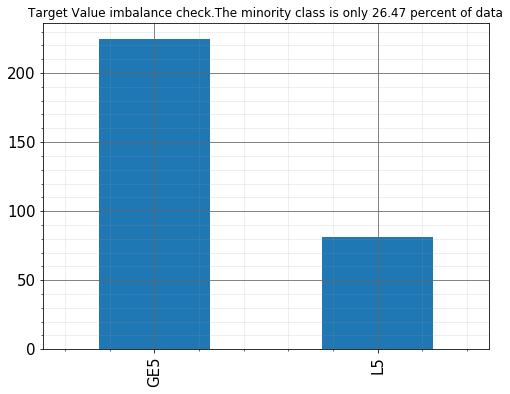

In [6]:
print(df['Survived'].value_counts())
df['Survived'].value_counts().plot(kind='bar', figsize=(8,6),title="Target Value imbalance check.The minority class is only %0.2f percent of data"%(Counter(df["Survived"])["L5"]/len(df)*100),fontsize=15)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


Looking at the count for the two classes we can see that the classes are imbalanced
<blockquote>Observations</blockquote>
<ul>
<li>81 data points classified as L5.</li>
<li>225 data points classfifed as GE5</li>
<li>Minority class only makes 26 percent of the data</li>
</ul>


<h3> Prepration of data for training and evaluvation</h3>
In order for training to done we now have to split the dataframe into input and target

In [7]:
# o,1 mapping for easier implimentation where positive class will be majority
df.loc[df['Survived'] == 'GE5', 'Survived'] = 1
df.loc[df['Survived'] == 'L5', 'Survived'] = 0


# Seperating to target value
y = df.pop('Survived').values
# Class attribute is now redundant therefore removing it
df.pop('Class')
# Training input dataframe
X = df.values
y=y.astype('int')

Initializing some helper functions

Creating a helper confusion matrix interface

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plt.show()

These are some dictionaries which will store results and gets converted to dataframes later

In [9]:
f1_scores = {'models': [],
        'f1': [],
             'hue_factor':[]
        }

f1_scores_cv = {'models': [],
        'f1': [],
             'hue_factor':[]
        }


cv_holdout = {'models': [],
            'hold_out_accuracy': [],
            'hold_out_recall':[],
          
              
            'cv_test_accuracy':[],
            'cv_predicted_recall':[],
           
             }

# Part 1

## Objective

<p> In this section since we have done the data prepration and some EDA, We will go about training the models and see how they perform. We will train four models and they are </p>

<ul>
    <li> K-NN </li>
    <li> Decesion Tree </li>
    <li> Logistic Regression </li>
    <li> Gradient boosting </li>
</ul>

The first objective will be to see how the model performs with <b> Hold-out</b> evaluvation and to see if there is a bias towards majority class. The reason why we have to check for bias is because of the highly imbalance in dataset. Next we will do the same with cross-validation and see if we are able to gain some insights.

### Metrics used for confirming hypothesis

The first hypothesis we have is that the models trained on the dataset are going to be highly biased towards the majority class. To see if this hypothesis is true or not we can check for the number of measures. The most obvious one is to measure the percentage of the minority class in the test set vs the predicted minority class. If the prediction value is low it means the model is not predicting enough negative classes, However, This metric has some flaws. It doesn't tell if the model prediction of negative classes is a true negative or not. Therefore to see the bias in our model and to see how the model is performing we will use <b>F1-score</b>and <b> Recall </b>
<br><br>
The best way to explain recall is with an example. Let's say we have 100 patients and 20 patients have cancer. If our model detects 20 patents to have cancer and they are true positives it means that we have a recall of 1. So recall in our case will be the ratio of the number of target values detected which is correct to the total number of target values in our test. Thus a low recall means we are not detecting enough of that particular class. For sake of simplicity, I will use F1 score for the plot as a lower F1 score also indicates a poor recall. 

## $k$-NN

The first model we will train is K-NN.We will first try to see how well KNN perorms with given data. A hold out of 50 percent will be used as we want to see if the minority class is being detected.  

In [10]:
kNN = KNeighborsClassifier(n_neighbors=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/2, random_state=42)
y_pred = kNN.fit(X_train, y_train).predict(X_test)

print(f'Accuracy of KNN is at:  {accuracy_score(y_pred, y_test)*100:.2f}% ')
pred_neg = Counter(y_pred)[0]
test_neg = Counter(y_test)[0]
print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))
cv_holdout["models"].append("KNN")
cv_holdout["hold_out_accuracy"].append(accuracy_score(y_pred, y_test))
cv_holdout["hold_out_recall"].append((recall_score(y_test, y_pred, pos_label=0)))

Accuracy of KNN is at:  77.12% 
Minority class in test set : 0.24
Predicted minority class : 0.16


We can see that accuracy of the classifier is at 77 percent however this will not give a full picture as we are dealing with an imbalanced dataset. To see how well the minority classes are predicted we need to take a look at precision and recall.

Confusion matrix, without normalization
[[ 13  23]
 [ 12 105]]


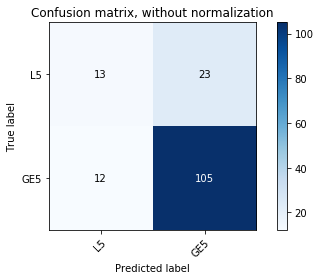

In [11]:
plot_confusion_matrix(y_test, y_pred, classes=["L5","GE5"],
                      title='Confusion matrix, without normalization')

The confusion matrix has given us a really good understanding of the model
<blockquote>
    <ul>
        <li> The total number of actual negative data(minority class) points in test set is 36 </li>
        <li> Total number of positive data(majority) in test set is 117 </li>
        <li> The model was able to correctly classify 13 negative data points out of 36</li>
        <li> Of the 25 it identified as negative 12 where wrong </li>
        <li> There are 117 positive data points and model identified 128 points as positive indicating a bias towards positve data </li>
    </ul>    
    
</blockquote>

To quantify the effects we need to use precision and recall

In [12]:
report = classification_report(y_test, y_pred)
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

           0       0.52      0.36      0.43        36
           1       0.82      0.90      0.86       117

    accuracy                           0.77       153
   macro avg       0.67      0.63      0.64       153
weighted avg       0.75      0.77      0.76       153



<blockquote> Observations for Majority Class </blockquote>
<ul>
    <li> The precesion for majority class is .82 which means of all the prediction the model said was positve 82 percent of it was actually positive. <br>A recall of .90 means of the positive data points we detected 90 percent of them</li>
</ul>
        
<blockquote> Observations for Minority Class </blockquote>
<ul>
    <li> The recall of the minority class is only at .36 which means of all the negative data points we only detected 36 percent of them</li>
    <li>The low recall value indicates that the model is having difficulty identifying the minority classes</li>
    
</ul>

We will use the F1 Score to quatify the perfomance into a single number

Storing all the required scores for compiling later

In [13]:
f1_scores["models"].append("K-NN")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=1))
f1_scores["hue_factor"].append(1)
# --------0-------
f1_scores["models"].append("K-NN")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=0))
f1_scores["hue_factor"].append(0)

Now that we have got all the perfomance matric for KNN we will repeat the same porcess for all the other models while keeping the same hold-out

# Decision Tree

In [14]:
dtree = DecisionTreeClassifier(criterion="entropy")
y_pred = dtree.fit(X_train, y_train).predict(X_test)

print(f'Accuracy of Decision tree is at:  {accuracy_score(y_pred, y_test)*100:.2f}% ')
pred_neg = Counter(y_pred)[0]
test_neg = Counter(y_test)[0]
print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))
cv_holdout["models"].append("DecisionTreeClassifier")
cv_holdout["hold_out_accuracy"].append(accuracy_score(y_pred, y_test))
cv_holdout["hold_out_recall"].append((recall_score(y_test, y_pred, pos_label=0)))

Accuracy of Decision tree is at:  64.71% 
Minority class in test set : 0.24
Predicted minority class : 0.27


Confusion matrix, without normalization
[[12 24]
 [30 87]]


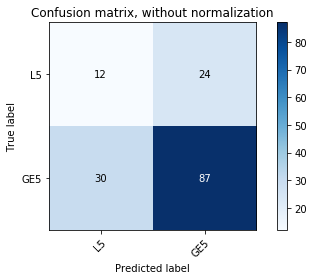

In [15]:
plot_confusion_matrix(y_test, y_pred, classes=["L5","GE5"],
                      title='Confusion matrix, without normalization')

In [16]:
report = classification_report(y_test, y_pred)
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

           0       0.29      0.33      0.31        36
           1       0.78      0.74      0.76       117

    accuracy                           0.65       153
   macro avg       0.53      0.54      0.54       153
weighted avg       0.67      0.65      0.66       153



Saving the metrics obtained for later

In [17]:
f1_scores["models"].append("Decision tree")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=1))
f1_scores["hue_factor"].append(1)
# --------0-------
f1_scores["models"].append("Decision tree")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=0))
f1_scores["hue_factor"].append(0)

# Logistic Regression

In [18]:
Lregr = LogisticRegression(random_state=0)
y_pred = Lregr.fit(X_train, y_train).predict(X_test)

print(f'Accuracy of Decision tree is at:  {accuracy_score(y_pred, y_test)*100:.2f}% ')

pred_neg = Counter(y_pred)[0]
test_neg = Counter(y_test)[0]

print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))

cv_holdout["models"].append("LogisticRegression")
cv_holdout["hold_out_accuracy"].append(accuracy_score(y_pred, y_test))
cv_holdout["hold_out_recall"].append((recall_score(y_test, y_pred, pos_label=0)))

Accuracy of Decision tree is at:  77.78% 
Minority class in test set : 0.24
Predicted minority class : 0.07


Confusion matrix, without normalization
[[  6  30]
 [  4 113]]


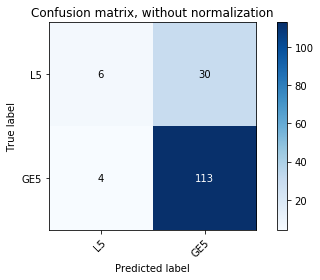

In [19]:
plot_confusion_matrix(y_test, y_pred, classes=["L5","GE5"],
                      title='Confusion matrix, without normalization')

In [20]:
report = classification_report(y_test, y_pred)
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

           0       0.60      0.17      0.26        36
           1       0.79      0.97      0.87       117

    accuracy                           0.78       153
   macro avg       0.70      0.57      0.57       153
weighted avg       0.75      0.78      0.73       153



Saving metric collected

In [21]:
f1_scores["models"].append("Logistic Regression")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=1))
f1_scores["hue_factor"].append(1)
# --------0-------
f1_scores["models"].append("Logistic Regression")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=0))
f1_scores["hue_factor"].append(0)

# Gradient Boosting

In [22]:
gboost = GradientBoostingClassifier(random_state=0)
y_pred = gboost.fit(X_train, y_train).predict(X_test)

print(f'Accuracy of Decision tree is at:  {accuracy_score(y_pred, y_test)*100:.2f}% ')

pred_neg = Counter(y_pred)[0]
test_neg = Counter(y_test)[0]

print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))


cv_holdout["models"].append("GradientBoostingClassifier")
cv_holdout["hold_out_accuracy"].append(accuracy_score(y_pred, y_test))
cv_holdout["hold_out_recall"].append((recall_score(y_test, y_pred, pos_label=0)))

Accuracy of Decision tree is at:  69.93% 
Minority class in test set : 0.24
Predicted minority class : 0.24


Confusion matrix, without normalization
[[13 23]
 [23 94]]


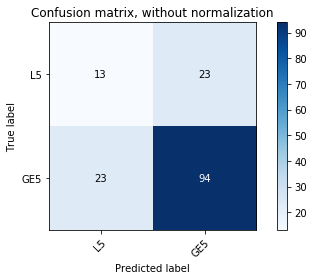

In [23]:
plot_confusion_matrix(y_test, y_pred, classes=["L5","GE5"],
                      title='Confusion matrix, without normalization')

In [24]:
report = classification_report(y_test, y_pred)
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

           0       0.36      0.36      0.36        36
           1       0.80      0.80      0.80       117

    accuracy                           0.70       153
   macro avg       0.58      0.58      0.58       153
weighted avg       0.70      0.70      0.70       153



In [25]:
f1_scores["models"].append("Gradient Boosting")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=1))
f1_scores["hue_factor"].append(1)
# --------0-------
f1_scores["models"].append("Gradient Boosting")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=0))
f1_scores["hue_factor"].append(0)

In [26]:
f1_scores = pd.DataFrame(f1_scores, columns = ['models', 'f1','hue_factor'])

# Part 1 Observations 

### Hypothesis
Our Hypothesis was that for the given dataset. All the models will be biased towards the majority class. We proposed to use F1 scores as stated earlier for evaluating the hypothesis. We will now use a grouped bar chart which will Plot the F1 Scores of each model as a pair of F1 scores for the majority and minority classes

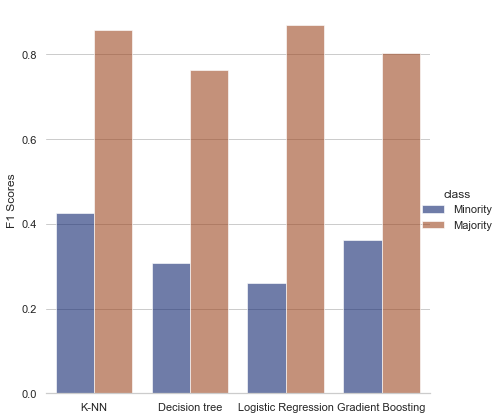

In [27]:
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")


# Draw a nested barplot by F1 scores
g = sns.catplot(
    data=f1_scores, kind="bar",
    x="models", y="f1", hue="hue_factor",
    ci="sd", palette="dark", alpha=.6, height=6,legend_out = True
)
new_labels = ['Minority', 'Majority']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.despine(left=True)
g.set_axis_labels("", "F1 Scores")
g.legend.set_title("class")

From the compiled results we can see a trend. We can observe that for each model the F1 scores are extremely low for the minority class. This observation validates our hypothesis that the models are indeed <b> biased to the majority class</b> 

Apart from the bias, it looks like most of the models performed similarly for the most part. Since accuracy will not be a suitable indicator of which model is better than others we will use <b>precision</b> and <b>recall</b>. The worst performer seems to be the decision tree which while the models such as logistic regression seem to be slightly better in this case. 

# Part 1.2
## Objective
The next objective is to see if we can get better results if we do Cross-validation instead of Hold-out testing. So we will repeat the model evaluation and try to see if the bias still exists or not. And then do a comparison of all the models trained using holdout and cross-validation

### Hypothesis

This time the hypothesis is that we are expected to see a similar trend of model bias but it's expected to be better than hold out. This is because in cross-validation our model gets to train with more data hence better performance.






container for holding all the matric collected

In [28]:
f1_scores_cv = {'models': [],
        'f1': [],
             'hue_factor':[]
        }

Compared to previous examples where we manually went through each models. Here we will use an iterator to go through each model and do cross validation and get results

In [29]:
kNN = KNeighborsClassifier(n_neighbors=3)
Lregr = LogisticRegression(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)
dtree = DecisionTreeClassifier(criterion='entropy')


# Define the classifier
classifier = [kNN,Lregr,gboost,dtree]

# KFold cross validation
cv = KFold(n_splits=10)

for classifier in classifier:
    y_pred = cross_val_predict(classifier, X, y, cv = cv)
    print(f"Model: {type(classifier).__name__}")
    print(classification_report(y, y_pred))
    print("--------------------------------")
    f1_scores_cv["models"].append(type(classifier).__name__)
    f1_scores_cv["f1"].append(f1_score(y, y_pred, pos_label=1))
    f1_scores_cv["hue_factor"].append(1)
#     --------0-------
    f1_scores_cv["models"].append(type(classifier).__name__)
    f1_scores_cv["f1"].append(f1_score(y, y_pred, pos_label=0))
    f1_scores_cv["hue_factor"].append(0)
    
#     ---------

    
    cv_holdout["cv_test_accuracy"].append(accuracy_score(y_pred, y))
    cv_holdout["cv_predicted_recall"].append((recall_score(y, y_pred, pos_label=0)))

Model: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.43      0.37      0.40        81
           1       0.78      0.82      0.80       225

    accuracy                           0.70       306
   macro avg       0.61      0.60      0.60       306
weighted avg       0.69      0.70      0.70       306

--------------------------------
Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.52      0.15      0.23        81
           1       0.76      0.95      0.84       225

    accuracy                           0.74       306
   macro avg       0.64      0.55      0.54       306
weighted avg       0.69      0.74      0.68       306

--------------------------------
Model: GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.40      0.28      0.33        81
           1       0.77      0.84      0.80       225

    accuracy                

In [30]:
f1_scores_cv = pd.DataFrame(f1_scores_cv, columns = ['models', 'f1','hue_factor'])

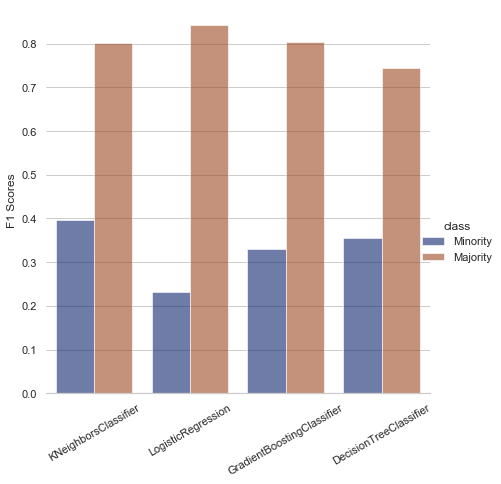

In [31]:

import seaborn as sns
sns.set_theme(style="whitegrid")


# Draw a nested barplot by F1 scores
g = sns.catplot(
    data=f1_scores_cv, kind="bar",
    x="models", y="f1", hue="hue_factor",
    ci="sd", palette="dark", alpha=.6, height=6,legend_out = True
)
new_labels = ['Minority', 'Majority']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.despine(left=True)
g.set_axis_labels("", "F1 Scores")
g.legend.set_title("class")
g.set_xticklabels(rotation=30)

## Observation

### Hypothesis
The hypothesis was that given that we are dealing with an unbalanced dataset we will experience a bias towards the majority classifier. Looking at the plot of the F1 scores of each classifier with respect to the classes. we can see the same trends we observed previously the F1 score for minority class is always less than the other indicating that the model is unable to perform well for minority classes. If we look at recall scores we can see that the minority class is not being predicted hence indicating the bias and validating the hypothesis 



In [32]:
cv_holdout = pd.DataFrame(cv_holdout, columns = ['models', 'hold_out_accuracy','cv_test_accuracy','hold_out_recall','cv_predicted_recall'])

### Hypothesis 2

The next hypothesis was that cross-validation will perform better than holdout as we train on more data while using hold-out we tend to have less data for training. Hence in our case, since the data set is small it may have an impact. 

For this, the result will be compiled as a table rather than as a graph as the observations are easier to comprehend in this way for our given data.




Creating the result table

In [33]:
cv_holdout

,models,hold_out_accuracy,cv_test_accuracy,hold_out_recall,cv_predicted_recall
0,KNN,0.771242,0.702614,0.361111,0.370370
1,DecisionTreeClassifier,0.647059,0.738562,0.333333,0.148148
2,LogisticRegression,0.777778,0.696078,0.166667,0.283951
3,GradientBoostingClassifier,0.699346,0.633987,0.361111,0.382716


Looking at the results of the holdout and cross-validation we can see the following results
<ul>
    <li> We don't see any major differences between the results of cross-validation and holdout </li>
    <li> The cross-validated model seems to have slightly better recall compared to hold out models except in logistic regression </li>
    <li> The accuracy of cross-validation seems to be generally lower than holdout. This doesn't mean that mold out is better recall which means we have less false positives and false negatives in the cross-validated model</li>
 </ul>   
 <blockquote> Note <br> The table shows only slight changes in accuracy or recall between both the evaluation this might be due to the small size of the dataset</blockquote>

# Part 2

# Objective

In this section we will try to rectify the issue of imbalance dataset. We propose 3 strategies.

<ul>
    <li>
        Over sampling minority class
    </li>
    <li> Under Sampling majority class </li>
    <li> Synthetic Minority Oversampling Technique SMOTE</li>
<ul>
       

       

Visualizing the data to see how the data is distributed. We can get a better understanding if we project the 3D data onto a plane like by using PCA

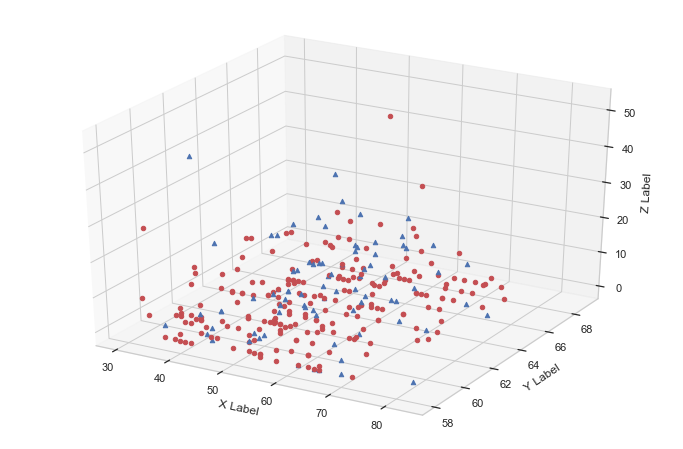

In [34]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

data = pd.read_csv("Survival.csv")

fig = plt.figure(figsize = (12, 8))

ax = fig.add_subplot(111, projection='3d')
axis = 0
for x in range(len(data)):
    if(data["Class"][x] == 1):
        ax.scatter(data["Age"][x], data["Year"][x], data["NNodes"][x],marker='o',c='r')
    else:
        ax.scatter(data["Age"][x], data["Year"][x], data["NNodes"][x],marker='^',c='b')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


container for storing metrics

In [35]:
resampling_data = {'models': [],
                   'f1-normal':[],
            'f1-oversample': [],
            'f1-undersample':[],
            'f1-smote':[]           
             }

# Oversample minority class

In this strategy we try to increase the number of samples of the minority class. This way both the classes will have same number of data. For the scikit implimentation it basically replicates some of the data in minority class. Since the data is just a copy it may not always provide better perfomance


In [36]:
from sklearn.utils import resample
df = pd.read_csv('survival.csv')

df['Survived'] = 1
df.loc[df['Class']==2,'Survived']=0
# Class attribute is now redundant therefore removing it
df.pop('Class')

# Seperating to target value
y = df['Survived']

# Training input dataframe
X = df
X = df.drop('Survived', axis=1)



<blockquote>
Note:
In this strategy we always oversample the data after doing the test-train split other wise the test set can also have same data from train data leaing to overfitting of data

</blockquote>



In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42,stratify=y)


In [38]:
# concatenate our training data back together
X = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)], axis=1)

In [39]:
# separate minority and majority classes
minority = X[X.Survived==0]
majority = X[X.Survived==1]

In [40]:
# upsample minority
minority_upsampled = resample(minority,
                          replace=True, # sample with replacement
                          n_samples=len(majority), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([majority, minority_upsampled])


In [41]:
# check new class counts
upsampled.Survived.value_counts()

1    113
0    113
Name: Survived, dtype: int64

Now we have equal amount

In [42]:
y_train = upsampled.Survived
X_train = upsampled.drop('Survived', axis=1)


Iterating through each model with new enhanced dataset

In [43]:
kNN = KNeighborsClassifier(n_neighbors=3)
Lregr = LogisticRegression(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)
dtree = DecisionTreeClassifier(criterion='entropy')


# Define the classifier
classifier = [kNN,Lregr,gboost,dtree]

# KFold cross validation

for classifier in classifier:
    upsampled_pred = classifier.fit(X_train, y_train).predict(X_test)
    print(f'Accuracy of {type(classifier).__name__} is at:  {accuracy_score(upsampled_pred, y_test)*100:.2f}% ')
    print(classification_report(y_test, upsampled_pred))
    print("---------")
    
    resampling_data["models"].append(type(classifier).__name__)
    resampling_data["f1-oversample"].append(f1_score(y_test, upsampled_pred, pos_label=0))
    

Accuracy of KNeighborsClassifier is at:  72.55% 
              precision    recall  f1-score   support

           0       0.49      0.41      0.45        41
           1       0.80      0.84      0.82       112

    accuracy                           0.73       153
   macro avg       0.64      0.63      0.63       153
weighted avg       0.71      0.73      0.72       153

---------
Accuracy of LogisticRegression is at:  73.20% 
              precision    recall  f1-score   support

           0       0.50      0.39      0.44        41
           1       0.79      0.86      0.82       112

    accuracy                           0.73       153
   macro avg       0.65      0.62      0.63       153
weighted avg       0.71      0.73      0.72       153

---------
Accuracy of GradientBoostingClassifier is at:  69.93% 
              precision    recall  f1-score   support

           0       0.43      0.37      0.39        41
           1       0.78      0.82      0.80       112

    accurac

# Resampling techniques — Undersample majority class

In this strategy we try to remove observations from the majority class. This way both the classes will have same number of data. This has a major drawback as we may be removing data which is imporatant and model may underfit as a result.
Again scikit learns resample method is used to make majority and minority to be same

In [44]:
majority_downsampled = resample(majority,
                                replace = False, # sample without replacement
                                n_samples = len(minority), # match minority n
                                random_state = 42) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([majority_downsampled, minority])

# checking counts
downsampled.Survived.value_counts()

1    40
0    40
Name: Survived, dtype: int64

We see a significant decrease in train data size

In [45]:

# checking counts
downsampled.Survived.value_counts()

1    40
0    40
Name: Survived, dtype: int64

In [46]:
y_train = downsampled.Survived
X_train = downsampled.drop('Survived', axis=1)

kNN = KNeighborsClassifier(n_neighbors=3)
Lregr = LogisticRegression(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)
dtree = DecisionTreeClassifier(criterion='entropy')


# Define the classifier
classifier = [kNN,Lregr,gboost,dtree]

for classifier in classifier:
    undersampled_pred = classifier.fit(X_train, y_train).predict(X_test)
    print(f'Accuracy of {type(classifier).__name__} is at:  {accuracy_score(undersampled_pred, y_test)*100:.2f}% ')
    print(classification_report(y_test, undersampled_pred))
    print("---------")
    
#     resampling_data["models"].append(type(classifier).__name__)
    resampling_data["f1-undersample"].append(f1_score(y_test, undersampled_pred, pos_label=0))

Accuracy of KNeighborsClassifier is at:  67.97% 
              precision    recall  f1-score   support

           0       0.43      0.59      0.49        41
           1       0.82      0.71      0.77       112

    accuracy                           0.68       153
   macro avg       0.63      0.65      0.63       153
weighted avg       0.72      0.68      0.69       153

---------
Accuracy of LogisticRegression is at:  75.16% 
              precision    recall  f1-score   support

           0       0.54      0.51      0.53        41
           1       0.82      0.84      0.83       112

    accuracy                           0.75       153
   macro avg       0.68      0.68      0.68       153
weighted avg       0.75      0.75      0.75       153

---------
Accuracy of GradientBoostingClassifier is at:  60.13% 
              precision    recall  f1-score   support

           0       0.36      0.63      0.46        41
           1       0.81      0.59      0.68       112

    accurac

# SMOTE

SMOTE stands for Synthetic Minority Oversampling. The basic idea is that if there are two points belonging to same class in a dimension space then its safe to assume that there are data points inbetween that belong to same class. SMOTE uses this concept of nearest neighnours to artificaially create new data points.

In [47]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
# Separate input features and target
y = df.Survived
X = df.drop('Survived', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

So We only do smote on training data Since we did a .5 split it means we are left with 153 data points(306/2). Initially we has 108 data points in majority and 45 data points in minority. After smote the number becomes 108 each

In [48]:
Counter(y_train)

Counter({1: 108, 0: 108})

In [49]:
kNN = KNeighborsClassifier(n_neighbors=3)
Lregr = LogisticRegression(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)
dtree = DecisionTreeClassifier(criterion='entropy')


# Define the classifier
classifier = [kNN,Lregr,gboost,dtree]

for classifier in classifier:
    smote = classifier.fit(X_train, y_train)
    smote_pred = smote.predict(X_test)
    print(f'Accuracy of {type(classifier).__name__} is at:  {accuracy_score(smote_pred, y_test)*100:.2f}% ')
    print(classification_report(y_test, smote_pred))
    print("---------")
#     resampling_data["models"].append(type(classifier).__name__)
    resampling_data["f1-smote"].append(f1_score(y_test, smote_pred, pos_label=0))

Accuracy of KNeighborsClassifier is at:  65.36% 
              precision    recall  f1-score   support

           0       0.33      0.44      0.38        36
           1       0.81      0.72      0.76       117

    accuracy                           0.65       153
   macro avg       0.57      0.58      0.57       153
weighted avg       0.69      0.65      0.67       153

---------
Accuracy of LogisticRegression is at:  67.32% 
              precision    recall  f1-score   support

           0       0.38      0.61      0.47        36
           1       0.85      0.69      0.76       117

    accuracy                           0.67       153
   macro avg       0.62      0.65      0.62       153
weighted avg       0.74      0.67      0.69       153

---------
Accuracy of GradientBoostingClassifier is at:  63.40% 
              precision    recall  f1-score   support

           0       0.34      0.58      0.43        36
           1       0.84      0.65      0.73       117

    accurac

# Results

Lets now look at the f1 scores of each model for the minority class. f1-normal is the original f1 values for hold-out.

<blockquote> Note:<br>We are using the F1 score for the <b>Minority class</b> and not the average F1 of model </blockquote>
    


In [50]:
resampling_data["f1-normal"]=f1_scores[f1_scores["hue_factor"]==0]["f1"]

In [51]:
resampling_data = pd.DataFrame(resampling_data, columns = ['models','f1-normal','f1-oversample','f1-undersample','f1-smote'])

In [52]:
resampling_data.set_index(['models'])

,f1-normal,f1-oversample,f1-undersample,f1-smote
models,,,,
KNeighborsClassifier,0.426230,0.447368,0.494845,0.376471
LogisticRegression,0.307692,0.438356,0.525000,0.468085
GradientBoostingClassifier,0.260870,0.394737,0.460177,0.428571
DecisionTreeClassifier,0.361111,0.324324,0.448598,0.361446


# Observation
<ul>
<li>f1-normal is the normal holdout results. From the above table we can see that oversampling, undersampling and smote improved the f1 are slightly higher than normal implimentation. Indicating that the data augmentation has improved the minority class predition by atleast a small amount.</li>
    <li>Contrary to my expectation the sampling technique that detects the minority class the best is <b>Undersampling</b> of majority data</li>
    

# Part 3
## Objective
Try SMOTE sampling technique on UCI breast-w dataset from Wisconsin hospital and see if it improves the perfomance of the model

In [53]:
dd = pd.read_csv("breast-w_csv.csv")

In [54]:
Counter(dd.Class)

Counter({'benign': 458, 'malignant': 241})

benign       458
malignant    241
Name: Class, dtype: int64


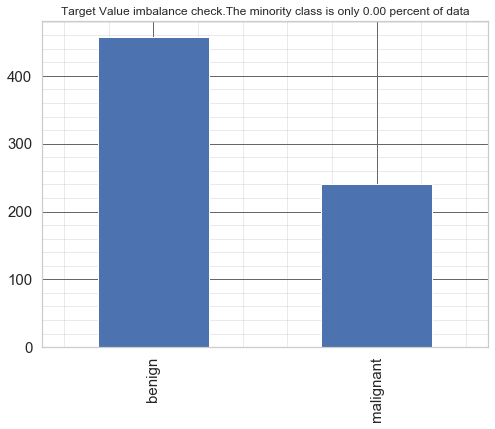

In [55]:
print(dd['Class'].value_counts())
dd['Class'].value_counts().plot(kind='bar', figsize=(8,6),title="Target Value imbalance check.The minority class is only %0.2f percent of data"%(Counter(dd["Class"])[1]/len(dd)*100),fontsize=15)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)



### Observation
We see that the dataset is also imbalanced

In [56]:
# removing null values
dd=dd.dropna()

In [57]:
# Creating target values
dd['target'] = 0
dd.loc[dd['Class']== "malignant",'target']=1
dd.head()

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class,target
0,5,1,1,1,2,1.0,3,1,1,benign,0
1,5,4,4,5,7,10.0,3,2,1,benign,0
2,3,1,1,1,2,2.0,3,1,1,benign,0
3,6,8,8,1,3,4.0,3,7,1,benign,0
4,4,1,1,3,2,1.0,3,1,1,benign,0


In [58]:

# Seperating to target value
y = dd.pop('target').values
# Class attribute is now redundant therefore removing it
dd.pop('Class')
# Training input dataframe
X = dd.values

Here we will use KNN and see the initial results. Then do the same with SMOTE data

In [59]:
kNN = KNeighborsClassifier(n_neighbors=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/2, random_state=42)
y_pred = kNN.fit(X_train, y_train).predict(X_test)
print(f'Accuracy of KNN is at:  {accuracy_score(y_pred, y_test)*100:.2f}% ')

pred_neg = Counter(y_pred)[1]
test_neg = Counter(y_test)[1]


Accuracy of KNN is at:  95.32% 


In [60]:
report = classification_report(y_test, y_pred)
print("Report:\n{}".format(report))

Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       218
           1       0.98      0.89      0.93       124

    accuracy                           0.95       342
   macro avg       0.96      0.94      0.95       342
weighted avg       0.95      0.95      0.95       342



### Observation
The model seems to fit well even before we did SMOTE however if we look the recall of minority class which is the 'malignant' tumor labeled 1 we see a recall of .89 indicating that there is some difficulty for model to predict minority class so we will apply SMOTE now

In [61]:

sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

With Smote we created equal number of minority and majority class by artifically generating minority class

In [62]:
Counter(y_train)

Counter({0: 226, 1: 226})

In [63]:
kNN = KNeighborsClassifier(n_neighbors=3)



# Define the classifier
classifier = [kNN]

for classifier in classifier:
    smote = classifier.fit(X_train, y_train)
    smote_pred = smote.predict(X_test)
    print(f'Accuracy of {type(classifier).__name__} is at:  {accuracy_score(smote_pred, y_test)*100:.2f}% ')
    print(classification_report(y_test, smote_pred))
    print("---------")

Accuracy of KNeighborsClassifier is at:  97.08% 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       218
           1       0.98      0.94      0.96       124

    accuracy                           0.97       342
   macro avg       0.97      0.96      0.97       342
weighted avg       0.97      0.97      0.97       342

---------


### Observation

With the new augmented data the recall of the dataset increased from .89 to .94 indicating that the SMOTE can in right circumstances improve perfomance of minority detection, However, SMOTE may not always be the only answer to imbalance in the dataset